In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import shapiro

In [122]:
df = pd.read_csv('./historicalData/processed_btc_data.csv', parse_dates=['snapped_at'])
df.set_index('snapped_at', inplace=True)  # Set 'Date' as the index

In [123]:
# Step 1: Set GARCH(1,1) parameters 
alpha0 = 0.000001 #long-run average variance
alpha1 = 0.08 #captures the impact of past squared returns
beta1  = 0.9 #captures the persistence of volatility

In [124]:
# Step 2: Create arrays to store conditional variances and residuals
sigma2 = np.zeros(n)
epsilon = returns - np.mean(returns)  # Residuals (demeaned returns)

In [125]:
# Step 3: Initialize sigma² with the unconditional variance
sigma2[0] = np.var(returns)

In [126]:
# Step 4: Recursive GARCH formula
for t in range(1, n):
    sigma2[t] = alpha0 + alpha1 * epsilon[t-1]**2 + beta1 * sigma2[t-1]

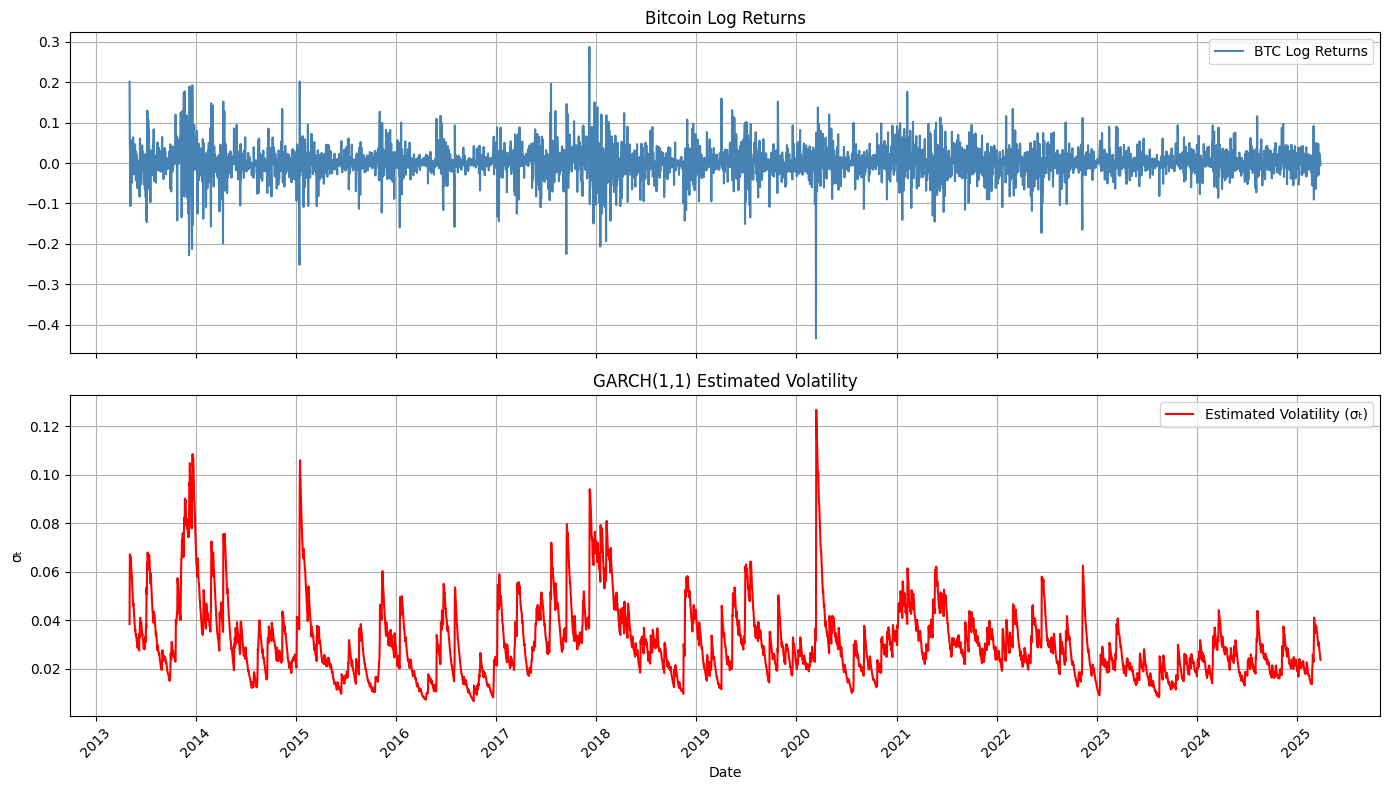

In [127]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Create a figure with 2 vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Subplot 1: Log returns
axs[0].plot(df.index, df['log_returns'], color='steelblue', label='BTC Log Returns')
axs[0].set_title("Bitcoin Log Returns")
axs[0].grid(True)
axs[0].legend()

# Subplot 2: GARCH volatility
axs[1].plot(df.index, np.sqrt(sigma2), color='red', label='Estimated Volatility (σₜ)')
axs[1].set_title("GARCH(1,1) Estimated Volatility")
axs[1].set_ylabel("σₜ")
axs[1].set_xlabel("Date")
axs[1].grid(True)
axs[1].legend()

# Format x-axis ticks as years
axs[1].xaxis.set_major_locator(mdates.YearLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

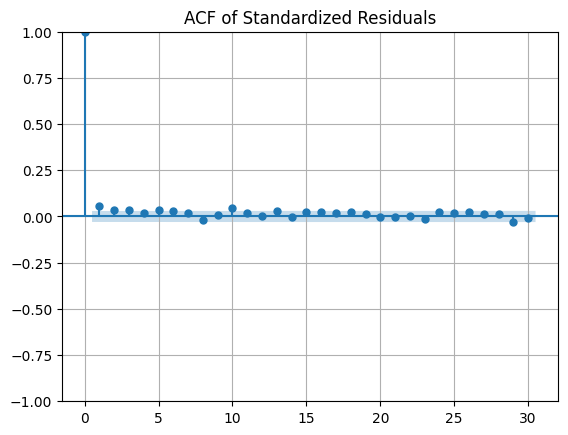

In [128]:
import pandas as pd

z = pd.Series(standardized_residuals, index=df.index)
plot_acf(z, lags=30)
plt.title("ACF of Standardized Residuals")
plt.grid(True)
plt.show()

In [129]:
conf = 1.96 / np.sqrt(len(standardized_residuals))
print(f"\n95% confidence interval for white noise: ±{conf:.5f}")


95% confidence interval for white noise: ±0.02974


In [130]:
acf_vals = manual_acf(standardized_residuals, max_lag=10)
conf = 1.96 / np.sqrt(len(standardized_residuals))

print(f"\n95% confidence interval for white noise: ±{conf:.5f}")

for lag, val in enumerate(acf_vals[1:], start=1):  # skip lag 0
    status = "✅ inside" if abs(val) < conf else "❌ outside"
    print(f"Lag {lag}: ACF = {val:.5f} → {status}")


95% confidence interval for white noise: ±0.02974
Lag 1: ACF = 0.05471 → ❌ outside
Lag 2: ACF = 0.03532 → ❌ outside
Lag 3: ACF = 0.03438 → ❌ outside
Lag 4: ACF = 0.01832 → ✅ inside
Lag 5: ACF = 0.03747 → ❌ outside
Lag 6: ACF = 0.02859 → ✅ inside
Lag 7: ACF = 0.01778 → ✅ inside
Lag 8: ACF = -0.01896 → ✅ inside
Lag 9: ACF = 0.01047 → ✅ inside
Lag 10: ACF = 0.04526 → ❌ outside


In [131]:
print(standardized_residuals)

[ 5.20006585  0.70108393  0.17720991 ...  0.02405546 -0.32385713
  0.06277209]


In [132]:
from scipy.stats import t

# Fit t-distribution to the data
params = t.fit(df['log_returns'])
loglik_t = np.sum(t.logpdf(df['log_returns'], *params))

In [133]:
from arch import arch_model
model = arch_model(returns, vol='GARCH', p=1, q=1, dist='t')  # <— use Student's t
model_fit = model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 81505.22252662713
Iteration:      2,   Func. Count:     23,   Neg. LLF: 94464.34554647846
Iteration:      3,   Func. Count:     39,   Neg. LLF: 4451288.4298532605
Iteration:      4,   Func. Count:     55,   Neg. LLF: 16600.416161543948
Iteration:      5,   Func. Count:     65,   Neg. LLF: 16600.77857973923
Iteration:      6,   Func. Count:     71,   Neg. LLF: 17864.474815190057
Iteration:      7,   Func. Count:     78,   Neg. LLF: 16380.875258750668
Iteration:      8,   Func. Count:     87,   Neg. LLF: -569.1451043570412
Iteration:      9,   Func. Count:     93,   Neg. LLF: -3550.6762285317054
Iteration:     10,   Func. Count:     99,   Neg. LLF: 323983.7655771278
Iteration:     11,   Func. Count:    115,   Neg. LLF: 36527.688148935995
Iteration:     12,   Func. Count:    122,   Neg. LLF: 66993.68642939371
Iteration:     13,   Func. Count:    129,   Neg. LLF: 57010.483309218645
Iteration:     14,   Func. Count:    136,   Neg. LLF: 5

/Users/mateobigearddasen/Documents/ECE/S2/ProbaStat/BtcPriceAnalysis/myenv/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001468. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [134]:
print(f"Student t-distribution log-likelihood: {loglik_t:.2f}")
print(f"GARCH(1,1) with t-distribution:        {loglik_garch_t:.2f}")

Student t-distribution log-likelihood: 8705.53
GARCH(1,1) with t-distribution:        8751.34


In [137]:
# Chi-Squared test
from scipy.stats import chi2

# Step 1: Compute the test statistic 
# df = 2 because GARCH(1,1) with t-dist adds 2 parameters compared to the t-distribution model
lrt_stat = 2 * (loglik_garch_t - loglik_t)

# Step 2: Compute the p-value
p_value = 1 - chi2.cdf(lrt_stat, df=2)

# Step 3: Print results and decision
print(f"LRT statistic: {lrt_stat:.4f}")
print(f"p-value: {p_value:.8f}")

# Step 4: Hypothesis test decision
alpha = 0.05  # significance level

if p_value < alpha:
    print("✅ Reject H0: The GARCH(1,1) with t-distribution significantly improves the model.")
else:
    print("❌ Fail to reject H0: The added complexity of GARCH is not statistically justified.")

LRT statistic: 91.6224
p-value: 0.00000000
✅ Reject H0: The GARCH(1,1) with t-distribution significantly improves the model.
